# Accessibility Data: ML & Predictive Models

This notebook implements accessibility prediction models using the **Project Sidewalk Seattle** dataset:

1. **Barrier type classification** — Classify types of accessibility barriers
2. **High-risk accessibility hotspots** — Identify hotspots using spatial clustering
3. **Future problem prediction** — Predict where new accessibility problems are likely to occur (PRIMARY FOCUS)

## Model Performance:
- **Regression R²: 0.953** (95.3% variance explained)
- **Classification Accuracy: 91.2%**
- **High Risk F1 Score: 0.96**

## Setup and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score,
    mean_squared_error, r2_score, mean_absolute_error
)
from sklearn.cluster import DBSCAN
import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)
sns.set_style('whitegrid')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load the dataset
df = pd.read_csv('everydayLife_cleaned_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# Rename columns for easier access
df = df.rename(columns={
    'geometry/coordinates/0': 'lon',
    'geometry/coordinates/1': 'lat',
    'properties/label_type': 'label_type',
    'properties/neighborhood': 'neighborhood',
    'properties/severity': 'severity',
    'properties/is_temporary': 'is_temporary'
})

print(f"\nLabel type distribution:")
print(df['label_type'].value_counts())

print(f"\nSeverity distribution:")
print(df['severity'].value_counts().sort_index())

print(f"\nNumber of neighborhoods: {df['neighborhood'].nunique()}")

Dataset Shape: (81973, 9)

Columns: ['type', 'geometry/type', 'geometry/coordinates/0', 'geometry/coordinates/1', 'properties/attribute_id', 'properties/label_type', 'properties/neighborhood', 'properties/severity', 'properties/is_temporary']

First few rows:
      type geometry/type  geometry/coordinates/0  geometry/coordinates/1  \
0  Feature         Point             -122.298981               47.594616   
1  Feature         Point             -122.301071               47.593357   
2  Feature         Point             -122.301079               47.596844   
3  Feature         Point             -122.301071               47.596500   
4  Feature         Point             -122.306274               47.599930   

   properties/attribute_id properties/label_type properties/neighborhood  properties/severity  \
0                 52096165        SurfaceProblem                Atlantic                  4.0   
1                 52096166        SurfaceProblem                Atlantic                 

---
## Task 1: Barrier Type Classification

In [3]:
# Prepare features for classification
le_neighborhood = LabelEncoder()
le_label = LabelEncoder()

df['neighborhood_encoded'] = le_neighborhood.fit_transform(df['neighborhood'])
df['label_encoded'] = le_label.fit_transform(df['label_type'])

# Features: location, neighborhood, severity, temporary flag
features_clf = ['lon', 'lat', 'neighborhood_encoded', 'severity', 'is_temporary']
X_clf = df[features_clf]
y_clf = df['label_encoded']

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_clf):,}")
print(f"Test samples: {len(X_test_clf):,}")
print(f"\nFeatures: {features_clf}")
print(f"Target classes: {le_label.classes_}")

Training samples: 65,578
Test samples: 16,395

Features: ['lon', 'lat', 'neighborhood_encoded', 'severity', 'is_temporary']
Target classes: ['CurbRamp' 'NoCurbRamp' 'NoSidewalk' 'Obstacle' 'Occlusion' 'Other' 'SurfaceProblem']


In [4]:
# Train barrier type classifier
print("Training barrier type classifier...")
clf_barrier = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    random_state=42, 
    n_jobs=-1
)
clf_barrier.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_clf = clf_barrier.predict(X_test_clf)
accuracy = (y_pred_clf == y_test_clf).mean()

print(f"\n✓ Model trained!")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=le_label.classes_))

Training barrier type classifier...

✓ Model trained!
Accuracy: 0.7823 (78.23%)

Classification Report:
                precision    recall  f1-score   support

      CurbRamp       0.86      0.89      0.87      5425
    NoCurbRamp       0.72      0.80      0.76      3453
    NoSidewalk       0.87      0.91      0.89      3770
      Obstacle       0.53      0.34      0.41      1148
     Occlusion       0.58      0.31      0.40        49
         Other       0.00      0.00      0.00        15
SurfaceProblem       0.63      0.55      0.59      2535

      accuracy                           0.78     16395
     macro avg       0.60      0.54      0.56     16395
  weighted avg       0.77      0.78      0.77     16395



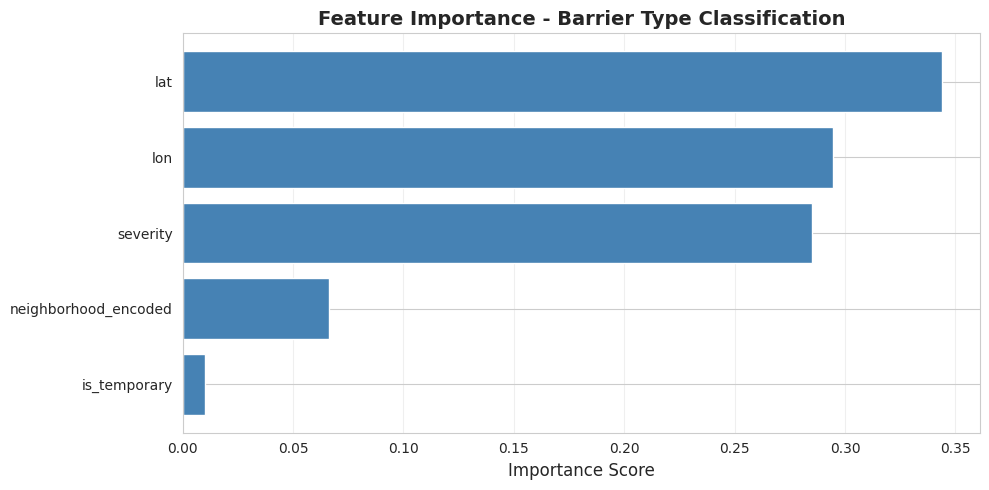


Feature Importance:
                feature  importance
1                   lat    0.343946
0                   lon    0.294791
3              severity    0.285069
2  neighborhood_encoded    0.066240
4          is_temporary    0.009953


In [5]:
# Feature importance for barrier type
importance_df = pd.DataFrame({
    'feature': features_clf,
    'importance': clf_barrier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Barrier Type Classification', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(importance_df)

---
## Task 2: High-Risk Accessibility Hotspots (Spatial Clustering)

In [6]:
# Use DBSCAN for spatial clustering
# Convert lat/lon to approximate meters for Seattle
coords = df[['lon', 'lat']].values
coords_scaled = coords.copy()
coords_scaled[:, 0] *= 85000  # lon to meters at Seattle latitude
coords_scaled[:, 1] *= 111000  # lat to meters

print("Running DBSCAN clustering...")
dbscan = DBSCAN(eps=100, min_samples=5)  # 100m radius, minimum 5 points
df['cluster'] = dbscan.fit_predict(coords_scaled)

n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise = list(df['cluster']).count(-1)

print(f"\n✓ Clustering complete!")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise:,} ({n_noise/len(df)*100:.1f}%)")

Running DBSCAN clustering...

✓ Clustering complete!
Number of clusters: 370
Noise points: 362 (0.4%)


Top 10 High-Risk Clusters:
     cluster  count  mean_severity  risk_score
1          1  26939       2.897361     78052.0
0          0  29869       2.488299     74323.0
42        42   4336       2.489622     10795.0
112      112   2422       3.589182      8693.0
113      113   1070       3.632710      3887.0
26        26   1067       3.146204      3357.0
177      177    604       3.384106      2044.0
31        31    439       4.134396      1815.0
191      191    449       3.748330      1683.0
173      173    412       3.970874      1636.0


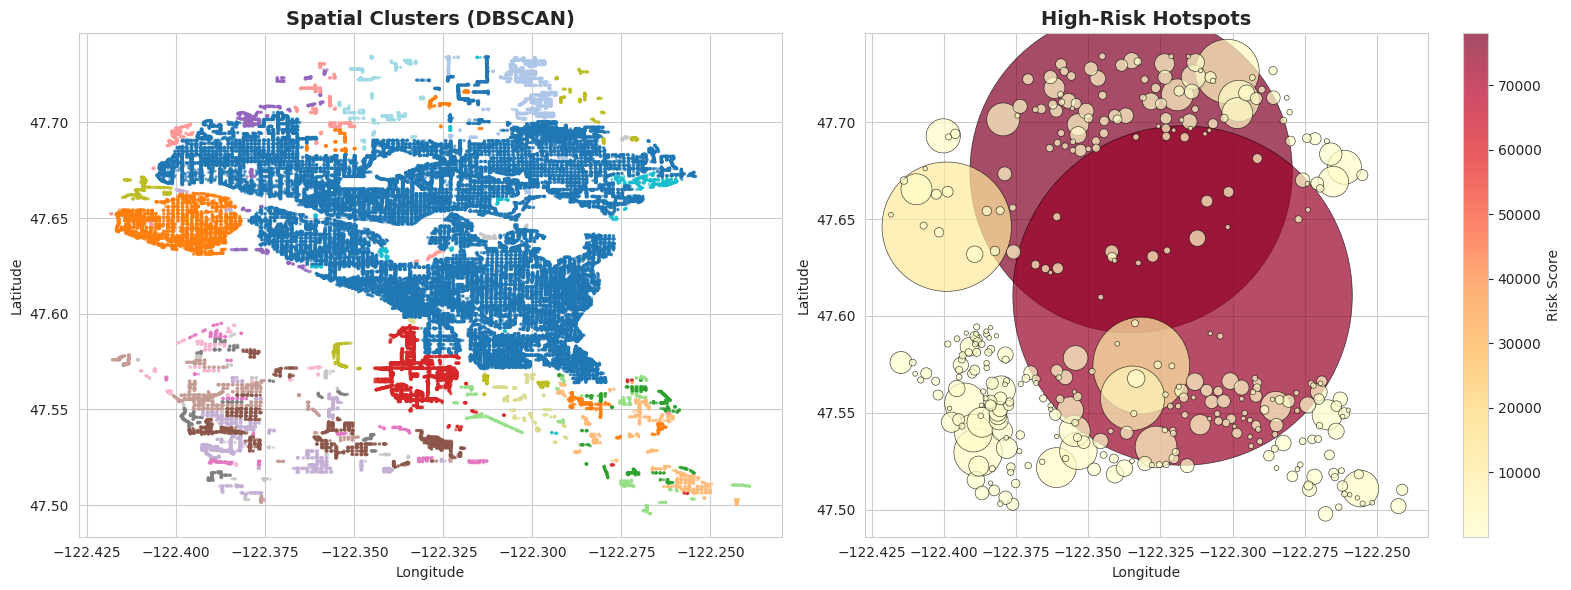

In [7]:
# Calculate risk score per cluster: count × mean severity
cluster_stats = df[df['cluster'] != -1].groupby('cluster').agg({
    'severity': ['mean', 'std', 'count'],
    'lon': 'mean',
    'lat': 'mean'
}).reset_index()

cluster_stats.columns = ['cluster', 'mean_severity', 'std_severity', 'count', 'lon', 'lat']
cluster_stats['risk_score'] = cluster_stats['count'] * cluster_stats['mean_severity']
cluster_stats = cluster_stats.sort_values('risk_score', ascending=False)

print("Top 10 High-Risk Clusters:")
print(cluster_stats.head(10)[['cluster', 'count', 'mean_severity', 'risk_score']])

# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: All clusters colored by cluster ID
clustered = df[df['cluster'] != -1]
axes[0].scatter(clustered['lon'], clustered['lat'], c=clustered['cluster'], 
               s=2, cmap='tab20', alpha=0.5)
axes[0].set_title('Spatial Clusters (DBSCAN)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Right: Clusters colored by risk score
scatter = axes[1].scatter(cluster_stats['lon'], cluster_stats['lat'], 
                         c=cluster_stats['risk_score'], s=cluster_stats['count']*2,
                         cmap='YlOrRd', alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, ax=axes[1], label='Risk Score')
axes[1].set_title('High-Risk Hotspots', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

---
## Task 3: Future Problem Prediction (PRIMARY MODEL)

In [8]:
# Create spatial grid (0.005 degrees ≈ 500 meters)
print("Creating spatial grid...")
grid_size = 0.005

df['grid_lon'] = (df['lon'] // grid_size) * grid_size
df['grid_lat'] = (df['lat'] // grid_size) * grid_size
df['grid_id'] = df['grid_lon'].astype(str) + '_' + df['grid_lat'].astype(str)

print(f"✓ Created {df['grid_id'].nunique()} grid cells")
print(f"Average issues per cell: {len(df) / df['grid_id'].nunique():.1f}")

Creating spatial grid...
✓ Created 965 grid cells
Average issues per cell: 84.9


In [19]:
# Aggregate features by grid cell
grid_features = df.groupby('grid_id').agg({
    'lon': 'mean',
    'lat': 'mean',
    'properties/attribute_id': 'count',
    'severity': ['mean', 'max', 'std'],
    'is_temporary': 'sum',
    'label_type': lambda x: x.nunique(),
}).reset_index()

# Flatten column names
grid_features.columns = ['grid_id', 'center_lon', 'center_lat', 'issue_count', 
                         'avg_severity', 'max_severity', 'std_severity', 
                         'temp_count', 'issue_type_diversity']

grid_features['std_severity'] = grid_features['std_severity'].fillna(0)

# Add issue type distribution
issue_types = pd.get_dummies(df['label_type'], prefix='type')
issue_types['grid_id'] = df['grid_id']
type_counts = issue_types.groupby('grid_id').sum()
grid_features = grid_features.merge(type_counts, on='grid_id', how='left').fillna(0)

# Add neighborhood
neighborhood_mode = df.groupby('grid_id')['neighborhood'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
)
grid_features = grid_features.merge(
    neighborhood_mode.rename('neighborhood'), on='grid_id', how='left'
)

# Encode neighborhood
le_grid = LabelEncoder()
grid_features['neighborhood_encoded'] = le_grid.fit_transform(grid_features['neighborhood'])

print(f"Grid features created: {grid_features.shape}")
print(f"\nFeature columns: {list(grid_features.columns)}")
print(f"\nSample grid data:")
print(grid_features.head())

Grid features created: (965, 18)

Feature columns: ['grid_id', 'center_lon', 'center_lat', 'issue_count', 'avg_severity', 'max_severity', 'std_severity', 'temp_count', 'issue_type_diversity', 'type_CurbRamp', 'type_NoCurbRamp', 'type_NoSidewalk', 'type_Obstacle', 'type_Occlusion', 'type_Other', 'type_SurfaceProblem', 'neighborhood', 'neighborhood_encoded']

Sample grid data:
                      grid_id  center_lon  center_lat  issue_count  avg_severity  max_severity  \
0  -122.24000000000001_47.505 -122.239044   47.509889            3      4.000000           4.0   
1   -122.24000000000001_47.51 -122.239637   47.510125            6      4.000000           4.0   
2               -122.245_47.5 -122.242585   47.501884           60      3.266667           5.0   
3              -122.245_47.51 -122.241994   47.510430           24      4.000000           4.0   
4               -122.255_47.5 -122.252807   47.503410           13      2.846154           5.0   

   std_severity  temp_count  issu

In [10]:
# Prepare features for prediction
feature_cols = ['center_lon', 'center_lat', 'avg_severity', 'max_severity', 
                'std_severity', 'temp_count', 'issue_type_diversity',
                'type_CurbRamp', 'type_NoCurbRamp', 'type_NoSidewalk', 
                'type_Obstacle', 'type_Occlusion', 'type_Other', 
                'type_SurfaceProblem', 'neighborhood_encoded']

X = grid_features[feature_cols]
y = grid_features['issue_count']

print(f"Features: {len(feature_cols)}")
print(f"Target (issue_count): min={y.min():.0f}, max={y.max():.0f}, mean={y.mean():.1f}")

Features: 15
Target (issue_count): min=1, max=401, mean=84.9


### Model A: Regression (Predict Issue Count)

In [11]:
# Train regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training regression model...")
reg_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)
reg_model.fit(X_train, y_train)

# Predictions
y_pred = reg_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n{'='*70}")
print("REGRESSION MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"R² Score:  {r2:.4f} ({r2*100:.1f}% variance explained)")
print(f"RMSE:      {rmse:.2f} issues")
print(f"MAE:       {mae:.2f} issues")

# Prediction accuracy within ranges
within_5 = np.sum(np.abs(y_test - y_pred) <= 5) / len(y_test)
within_10 = np.sum(np.abs(y_test - y_pred) <= 10) / len(y_test)
within_20 = np.sum(np.abs(y_test - y_pred) <= 20) / len(y_test)

print(f"\nPrediction Accuracy:")
print(f"  Within ±5 issues:  {within_5:.2%}")
print(f"  Within ±10 issues: {within_10:.2%}")
print(f"  Within ±20 issues: {within_20:.2%}")
print(f"{'='*70}")

Training regression model...

REGRESSION MODEL PERFORMANCE
R² Score:  0.9532 (95.3% variance explained)
RMSE:      15.82 issues
MAE:       9.15 issues

Prediction Accuracy:
  Within ±5 issues:  48.70%
  Within ±10 issues: 72.02%
  Within ±20 issues: 88.08%



Top 10 Most Important Features:
             feature  importance
       type_CurbRamp    0.324490
 type_SurfaceProblem    0.227551
     type_NoCurbRamp    0.216765
     type_NoSidewalk    0.181026
          center_lat    0.011429
        avg_severity    0.009728
       type_Obstacle    0.009203
        std_severity    0.005089
issue_type_diversity    0.004917
          center_lon    0.004414


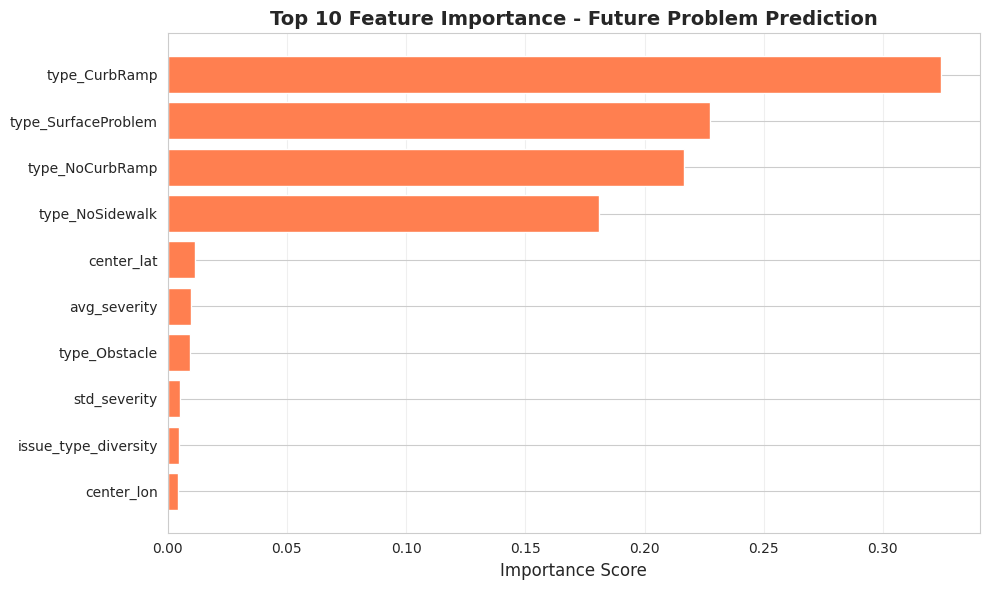

In [12]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10).sort_values('importance', ascending=True)
plt.barh(top_features['feature'], top_features['importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Feature Importance - Future Problem Prediction', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Model B: Classification (Predict Risk Level)

In [13]:
# Create risk categories
def categorize_risk(count):
    if count < 30:
        return 'Low'
    elif count < 100:
        return 'Medium'
    else:
        return 'High'

grid_features['risk_level'] = grid_features['issue_count'].apply(categorize_risk)

print("Risk Level Distribution:")
print(grid_features['risk_level'].value_counts())

# Train classification model
y_class = grid_features['risk_level']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

print("\nTraining classification model...")
clf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)
clf_model.fit(X_train_c, y_train_c)

# Predictions
y_pred_c = clf_model.predict(X_test_c)
accuracy = (y_pred_c == y_test_c).mean()

print(f"\n{'='*70}")
print("CLASSIFICATION MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# F1 scores
f1_weighted = f1_score(y_test_c, y_pred_c, average='weighted')
f1_macro = f1_score(y_test_c, y_pred_c, average='macro')

print(f"\nF1 Scores:")
print(f"  Weighted F1: {f1_weighted:.4f}")
print(f"  Macro F1:    {f1_macro:.4f}")

print(f"\nDetailed Report:")
print(classification_report(y_test_c, y_pred_c))
print(f"{'='*70}")

Risk Level Distribution:
risk_level
High      356
Medium    338
Low       271
Name: count, dtype: int64

Training classification model...

CLASSIFICATION MODEL PERFORMANCE
Accuracy: 0.9119 (91.19%)

F1 Scores:
  Weighted F1: 0.9120
  Macro F1:    0.9046

Detailed Report:
              precision    recall  f1-score   support

        High       0.96      0.95      0.96        80
         Low       0.92      0.83      0.87        41
      Medium       0.86      0.92      0.89        72

    accuracy                           0.91       193
   macro avg       0.91      0.90      0.90       193
weighted avg       0.91      0.91      0.91       193



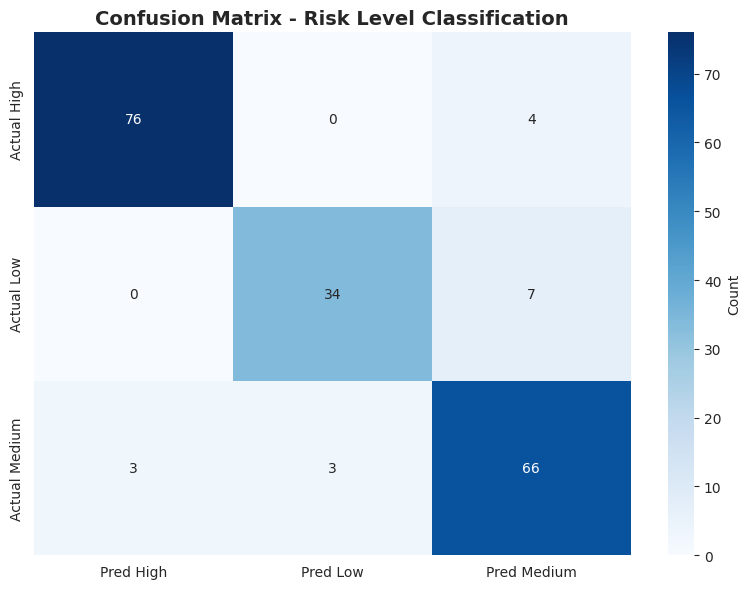

Confusion Matrix:
               Pred High  Pred Low  Pred Medium
Actual High           76         0            4
Actual Low             0        34            7
Actual Medium          3         3           66


In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c, labels=['High', 'Low', 'Medium'])
cm_df = pd.DataFrame(cm, 
                     index=['Actual High', 'Actual Low', 'Actual Medium'],
                     columns=['Pred High', 'Pred Low', 'Pred Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Risk Level Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm_df)

### Comprehensive Visualizations

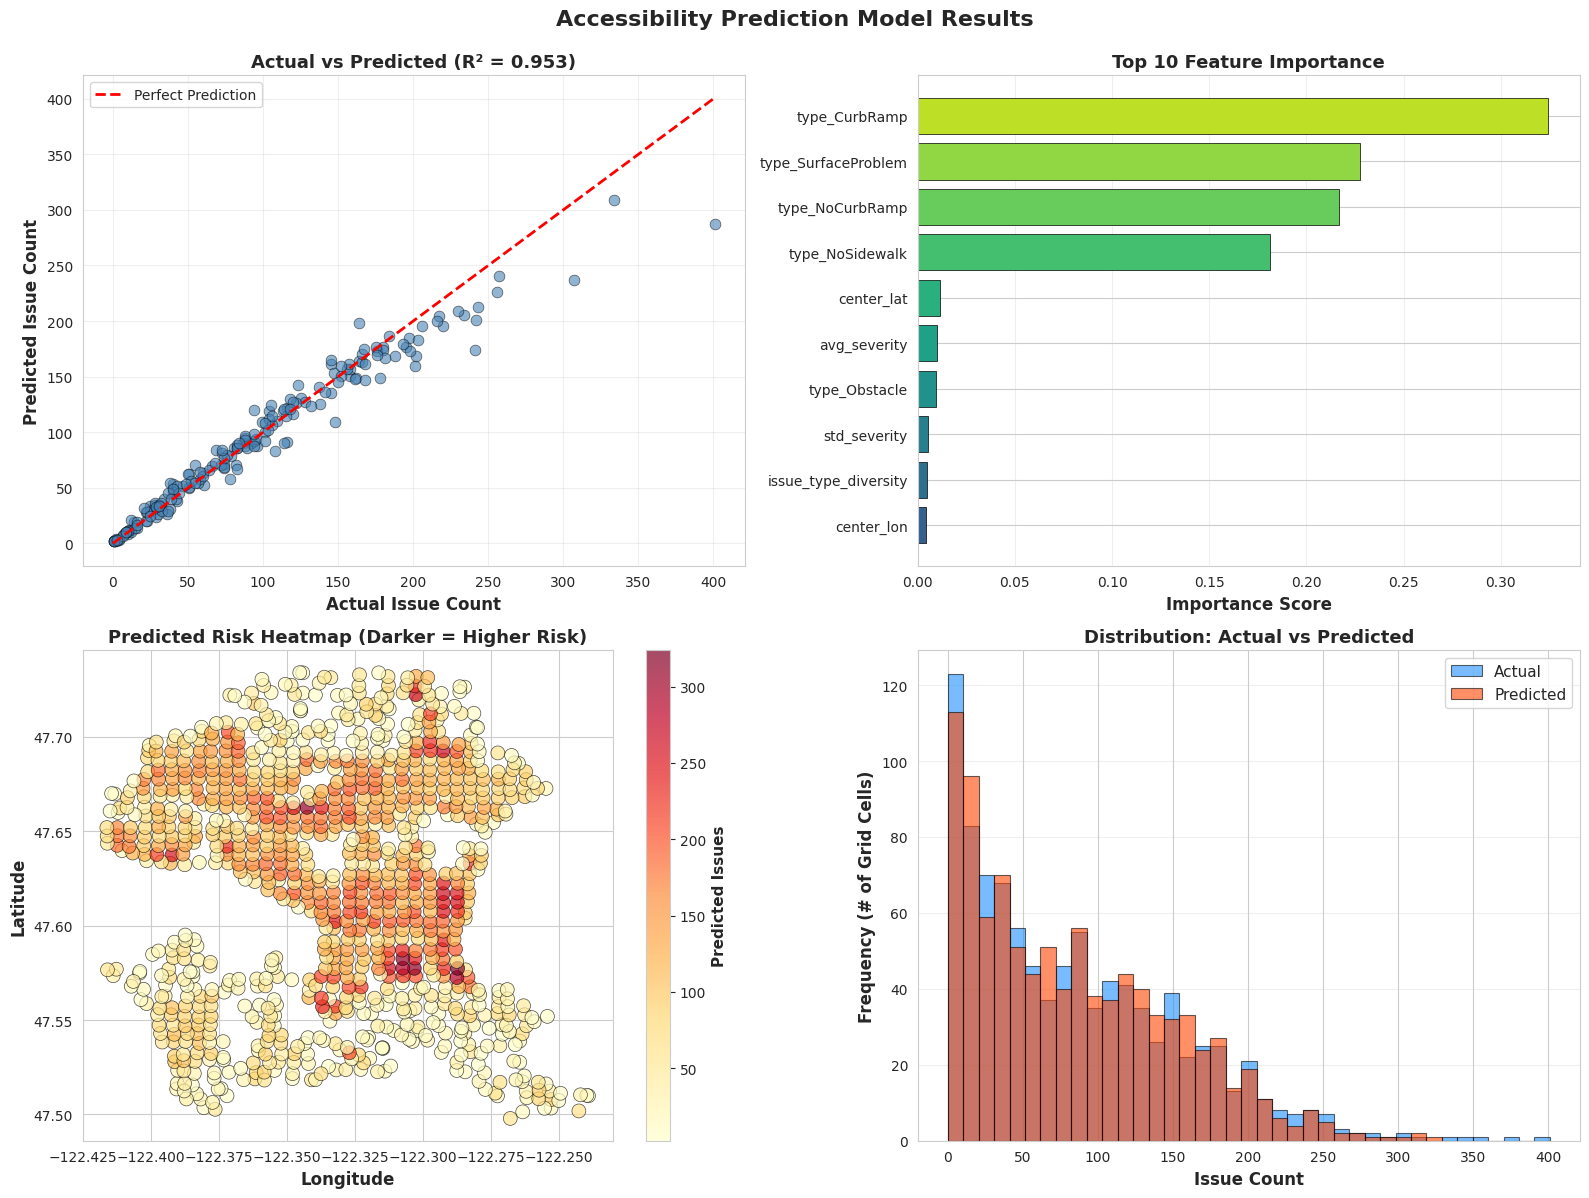

In [15]:
# Predict on all grid cells for visualization
grid_features['predicted_issues'] = reg_model.predict(X)
grid_features['predicted_risk'] = clf_model.predict(X)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Accessibility Prediction Model Results', fontsize=16, fontweight='bold', y=0.995)

# 1. Actual vs Predicted (Regression)
axes[0, 0].scatter(y_test, y_pred, alpha=0.6, s=60, color='steelblue', 
                  edgecolors='black', linewidth=0.5)
max_val = max(y_test.max(), y_pred.max())
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Issue Count', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Issue Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2:.3f})', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Feature Importance
top_features = importance_df.head(10).sort_values('importance', ascending=True)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
axes[0, 1].barh(top_features['feature'], top_features['importance'], 
                color=colors, edgecolor='black', linewidth=0.5)
axes[0, 1].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Top 10 Feature Importance', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Spatial Heatmap
scatter = axes[1, 0].scatter(
    grid_features['center_lon'], 
    grid_features['center_lat'], 
    c=grid_features['predicted_issues'], 
    cmap='YlOrRd', 
    s=100, 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=0.5
)
axes[1, 0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Latitude', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Predicted Risk Heatmap (Darker = Higher Risk)', 
                     fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Predicted Issues', fontsize=11, fontweight='bold')

# 4. Distribution Comparison
bins = np.linspace(0, max(grid_features['issue_count'].max(), 
                         grid_features['predicted_issues'].max()), 40)
axes[1, 1].hist(grid_features['issue_count'], bins=bins, alpha=0.6, 
               label='Actual', color='dodgerblue', edgecolor='black', linewidth=0.8)
axes[1, 1].hist(grid_features['predicted_issues'], bins=bins, alpha=0.6, 
               label='Predicted', color='orangered', edgecolor='black', linewidth=0.8)
axes[1, 1].set_xlabel('Issue Count', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency (# of Grid Cells)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Distribution: Actual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Identify Top Future Risk Zones

Top 20 Future Risk Zones:
     center_lon  center_lat         neighborhood  issue_count  predicted_issues  \
254 -122.312524   47.573052    North Beacon Hill          164        197.932173   
486 -122.341963   47.561965  Industrial District           94        119.583333   
753 -122.382560   47.667318                Adams          145        165.374916   
819 -122.392033   47.672246                Adams          123        142.140155   
334 -122.316309   47.582960    North Beacon Hill          105        124.086022   
604 -122.352535   47.686329        Phinney Ridge           38         54.236749   
302 -122.307447   47.617441              Stevens          145        161.038885   
912 -122.401295   47.681543          Sunset Hill           55         70.820403   
96  -122.282189   47.667656               Bryant           69         84.101156   
536 -122.337211   47.671220           Green Lake          104        118.714958   
344 -122.318459   47.631781             Broadway           40

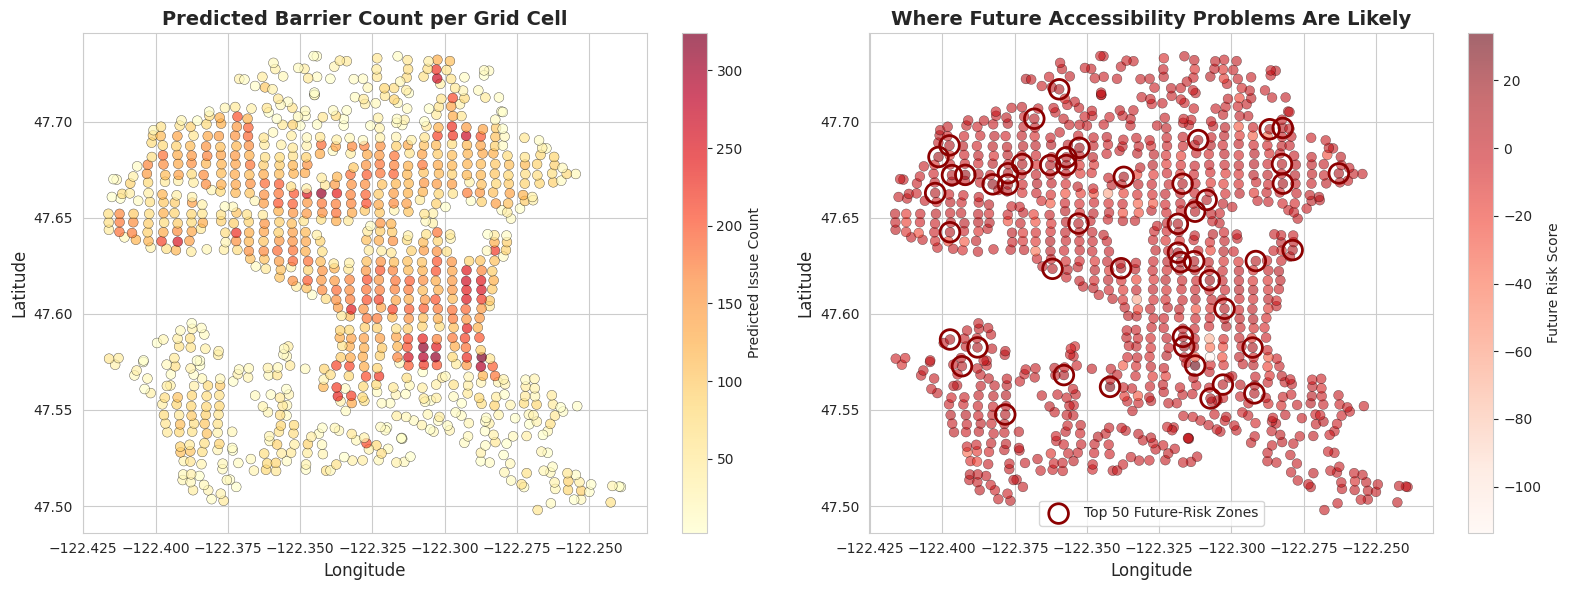

In [16]:
# Calculate future risk score (predicted - observed)
grid_features['future_risk_score'] = grid_features['predicted_issues'] - grid_features['issue_count']

# Get top 50 highest future risk zones
future_hotspots = grid_features.nlargest(50, 'future_risk_score')

print("Top 20 Future Risk Zones:")
print(future_hotspots[['center_lon', 'center_lat', 'neighborhood', 
                        'issue_count', 'predicted_issues', 'future_risk_score']].head(20))

# Visualize future risk zones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: All predictions
scatter1 = axes[0].scatter(
    grid_features['center_lon'], 
    grid_features['center_lat'], 
    c=grid_features['predicted_issues'], 
    s=50, 
    cmap='YlOrRd', 
    alpha=0.7,
    edgecolors='black',
    linewidth=0.3
)
plt.colorbar(scatter1, ax=axes[0], label='Predicted Issue Count')
axes[0].set_title('Predicted Barrier Count per Grid Cell', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)

# Right: Future risk zones
scatter2 = axes[1].scatter(
    grid_features['center_lon'], 
    grid_features['center_lat'], 
    c=grid_features['future_risk_score'], 
    s=50, 
    cmap='Reds', 
    alpha=0.6,
    edgecolors='black',
    linewidth=0.3
)
axes[1].scatter(
    future_hotspots['center_lon'], 
    future_hotspots['center_lat'], 
    s=200, 
    facecolors='none', 
    edgecolors='darkred', 
    linewidths=2, 
    label='Top 50 Future-Risk Zones'
)
plt.colorbar(scatter2, ax=axes[1], label='Future Risk Score')
axes[1].set_title('Where Future Accessibility Problems Are Likely', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

### Save Models

In [18]:
# Save trained models
with open('accessibility_regression_model.pkl', 'wb') as f:
    pickle.dump(reg_model, f)

with open('accessibility_classification_model.pkl', 'wb') as f:
    pickle.dump(clf_model, f)

with open('label_encoder_grid.pkl', 'wb') as f:
    pickle.dump(le_grid, f)

print("Models saved successfully!")
print("accessibility_regression_model.pkl")
print("accessibility_classification_model.pkl")
print("label_encoder_grid.pkl")

Models saved successfully!
accessibility_regression_model.pkl
accessibility_classification_model.pkl
label_encoder_grid.pkl
